In [30]:
from IPython.display import Image
import torch
import numpy as np
import pandas as pd
from torch import nn

# Variational Autoencoder (VAE)

## Generative model

В классическом ML рассматриваются дискриминативные модели.

**Различающие (дискриминативные) модели** - *discriminative model* - класс моделей, которые обучают условное распределение данных $P(Y|X=x)$. 

То есть они учатся моделировать условную вероятность метки класса $y$ с учетом набора характеристик $x$.


**Порождающие (генеративные) модели** - *generative model* - класс моделей, которые обучают совместное распределение данных $P(X, Y)$. Из совместного распределения можно легко получить условное распределение $P(Y|X) = \frac{P(X, Y)}{P(X)}$, что позволит свести этот класс моделей к дискриминативным. Вычислить $P(X)$ из предыдущей формулы, зная совместное распределение можно следующим образом: $P(X)=\sum\limits_yP(X, Y = y)$.

Однако, на самом деле, совместное распределение дает больше информации и эту информацию можно использовать для решения других задач.

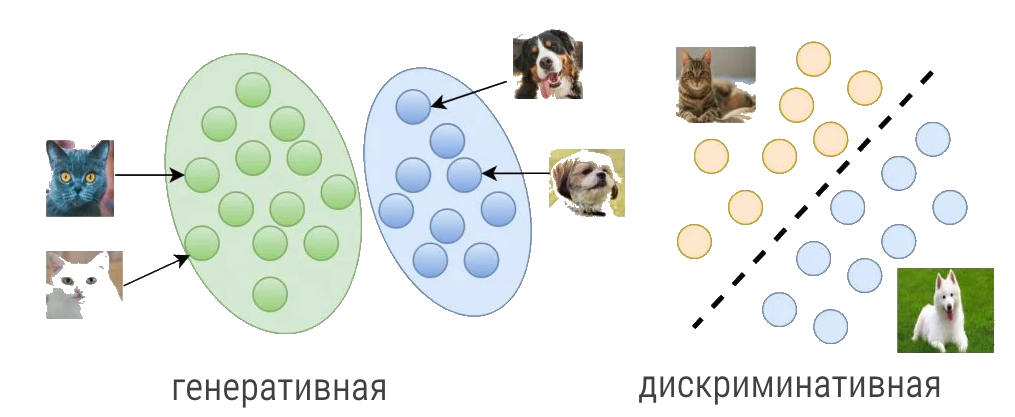

## Проблемы на практике (абьюз картинок)

1. Пусть у нас есть картинка, которую дискриминативная модель распознает, как кошку с очень большой вероятностью.

2. Добавим к ней невидимый шум, в результате чего визуально картинка не изменится.

3. Однако, наша дискриминативная модель может распознавать всю ту же кошку, например, как лошадь с очень большой вероятностью.

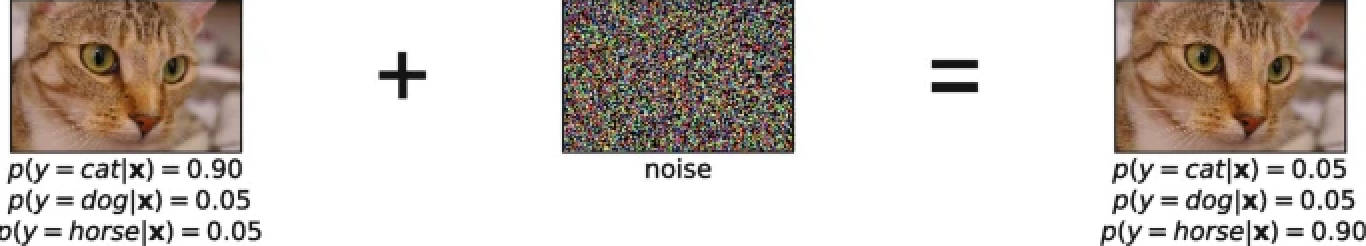

## Автоэнкодер - дискриминативная модель. А как сделать его генеративным?

Что мы хотим? Чтобы между кластерами в автоэнкодере не было существенных дырок. Чтобы наше простронство было непрерывным и из любой точки мы могли понять какой это объект.

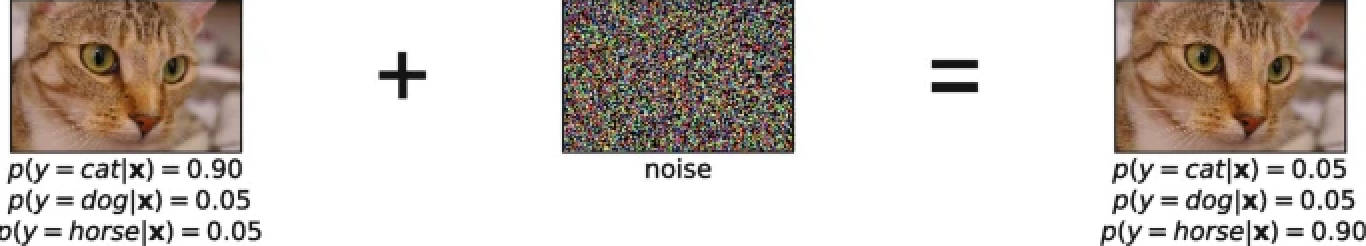

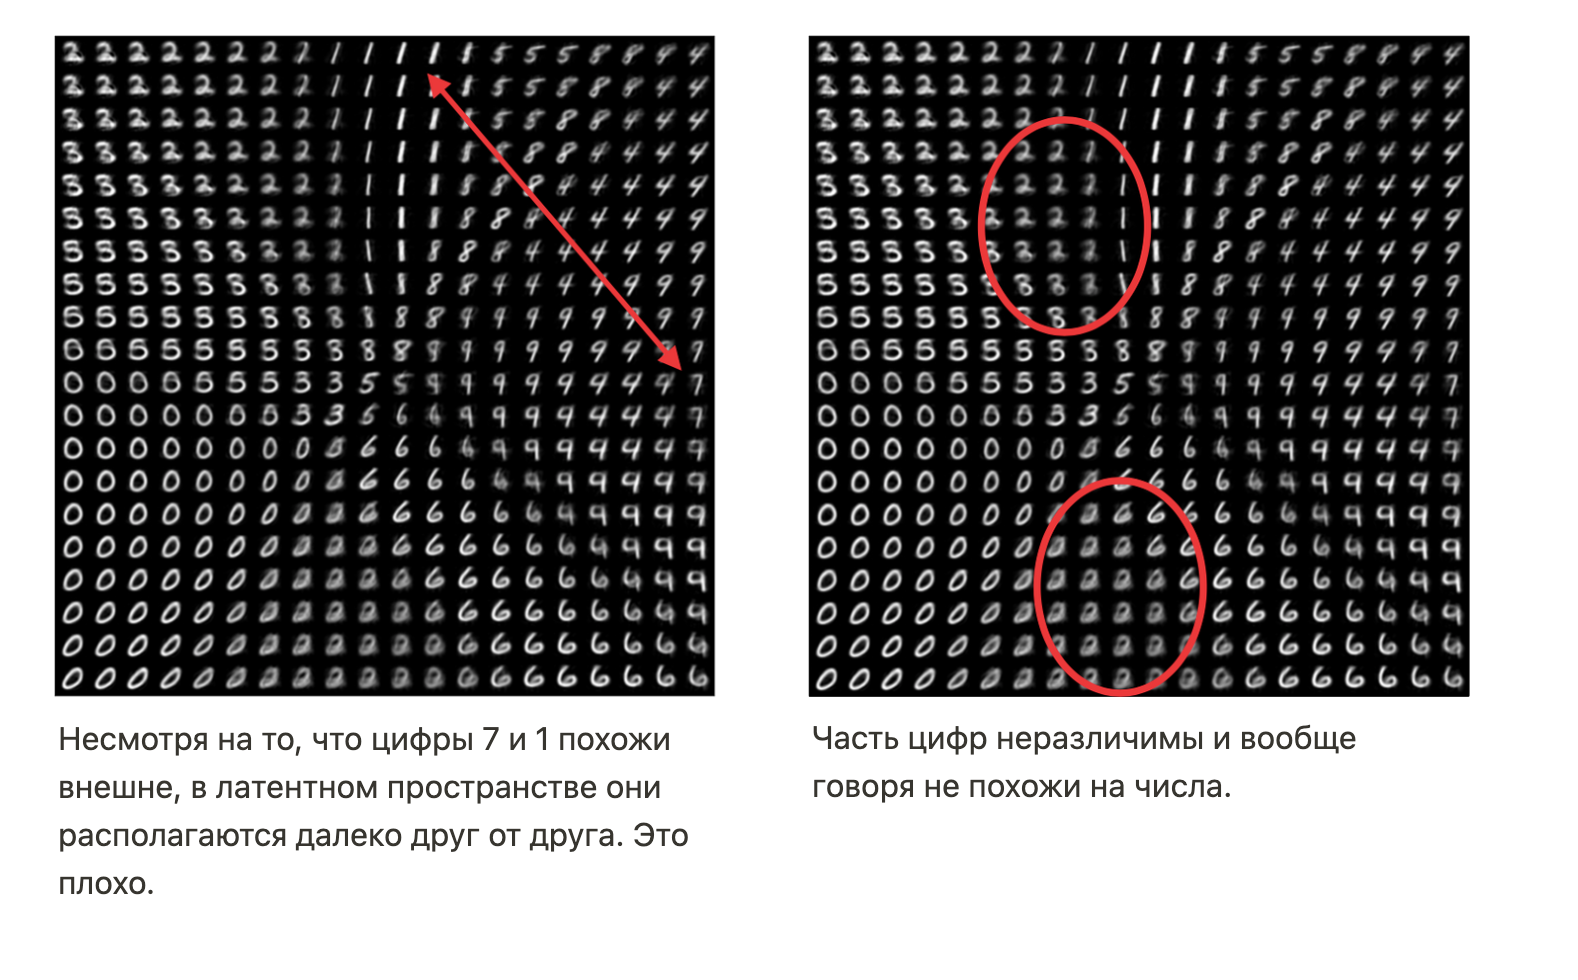

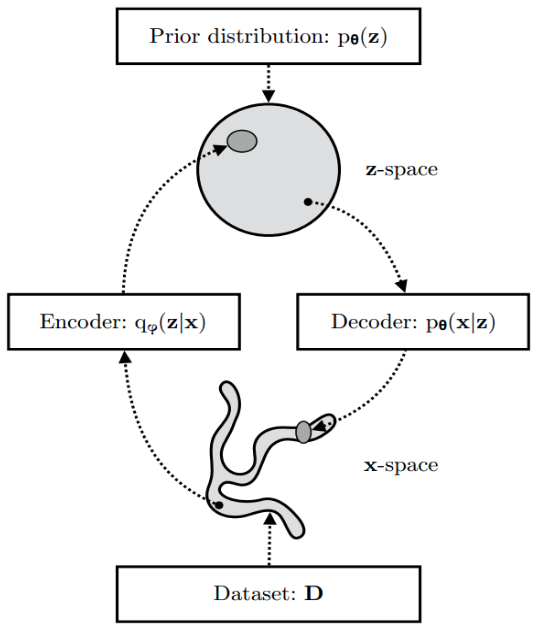

# Variational Autoencoder

**Идея** - а давайте для кажого сэмпла искать не сжатое представление, а некоторую **область**. Чем ближе к центру области, тем лучше, но нам нужна не **точка**, а целая **область**.

Давайте будем предсказывать **нормальное распределение** для каждого объекта. Тогда, чтобы задать область нам потребуется всего 2 параметра: матожидание и стандартное отклонение.


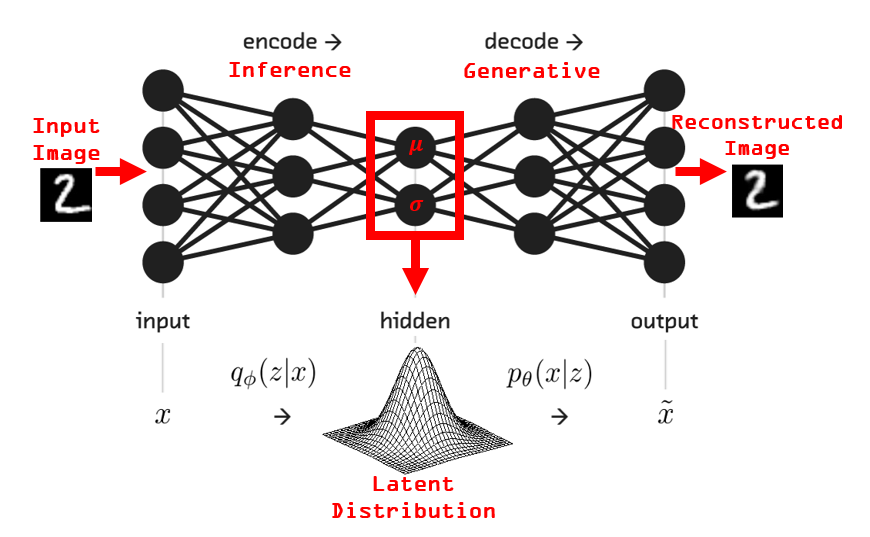

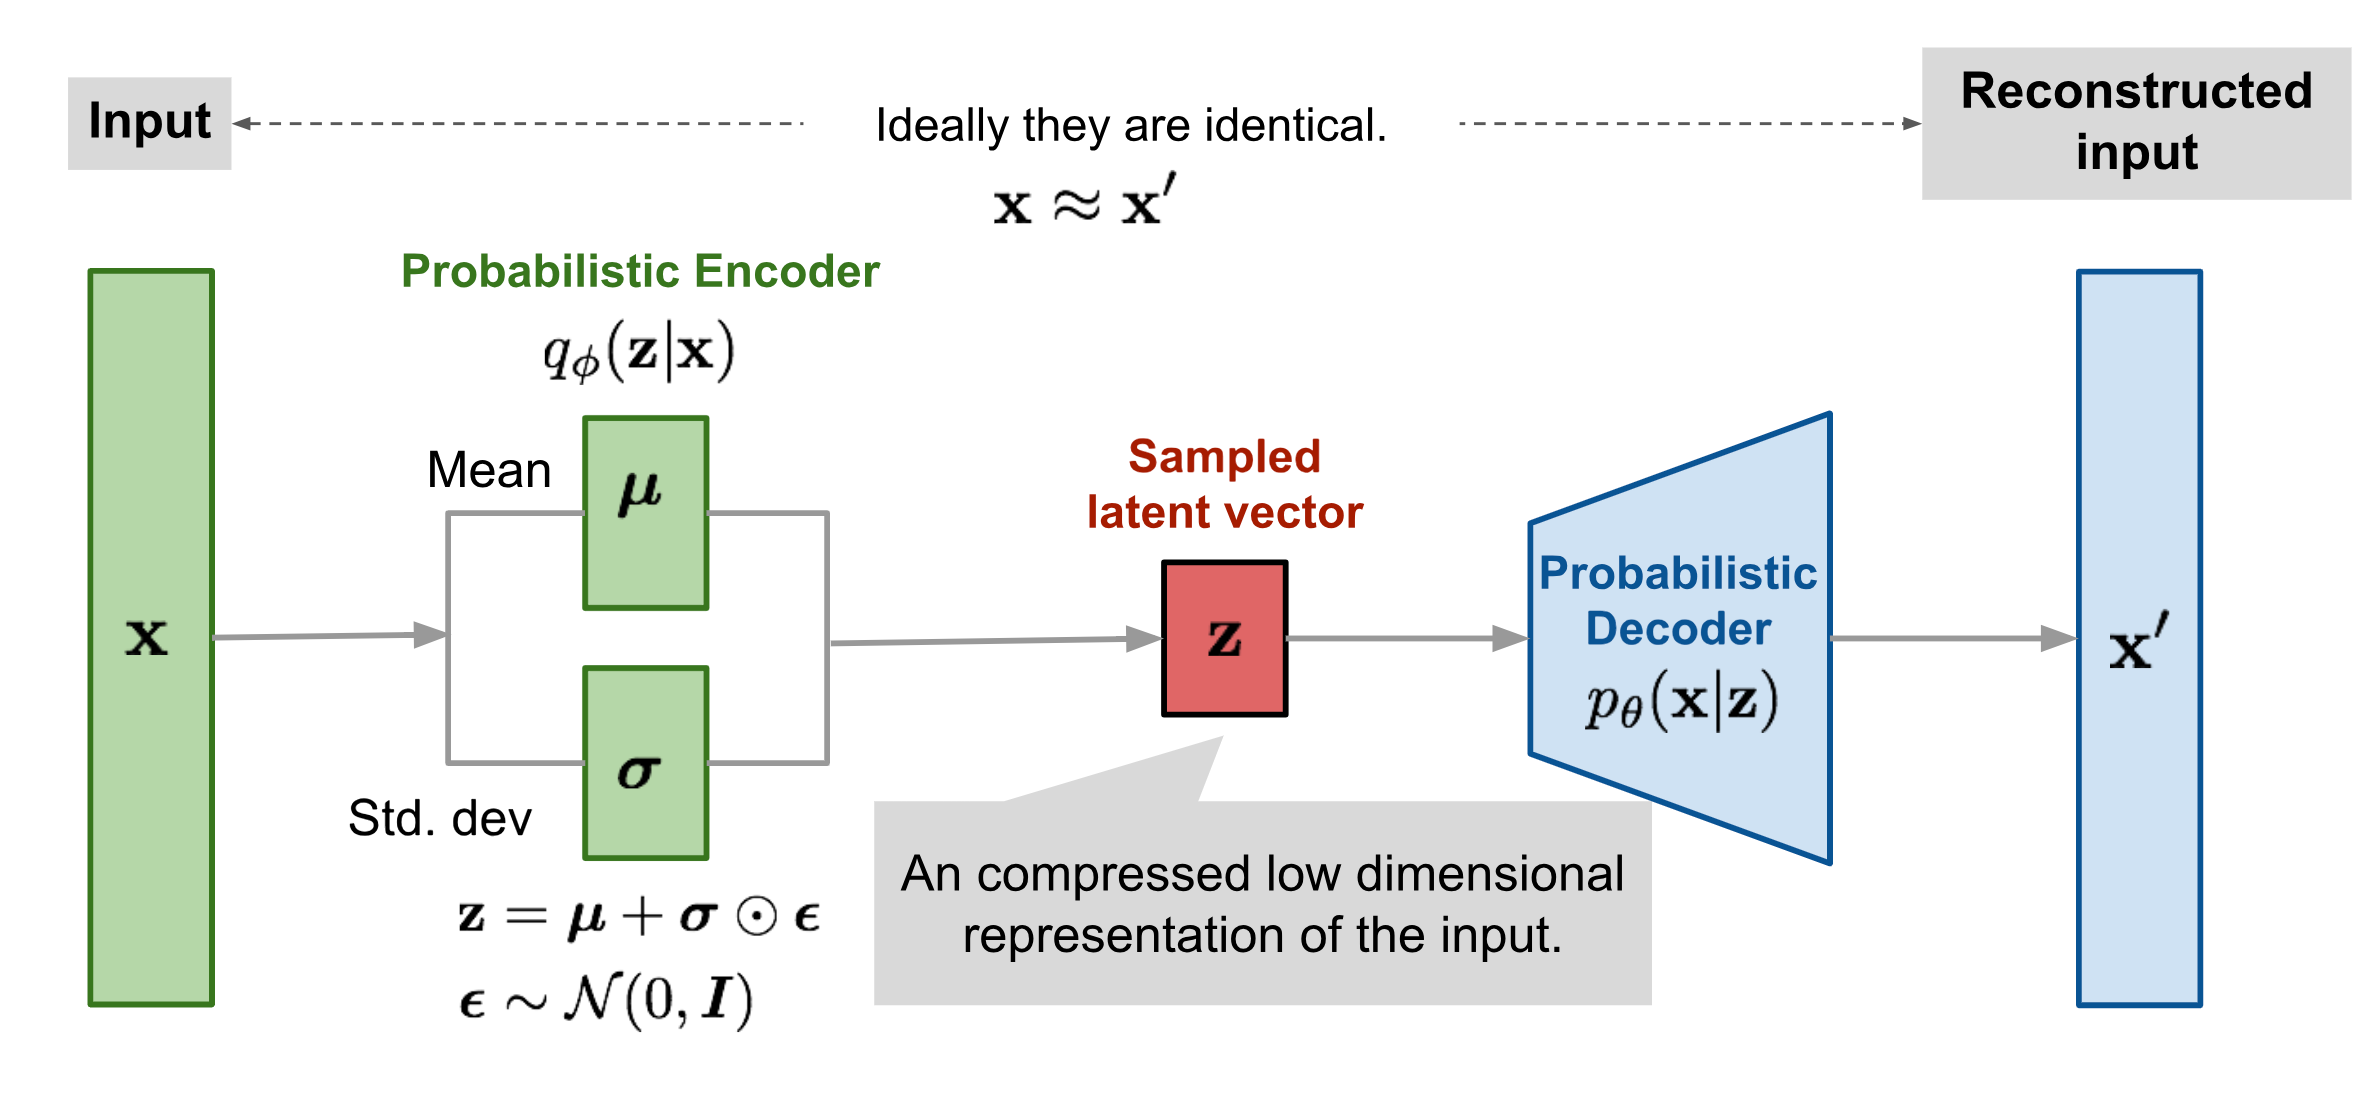

А как обучать распределение? Как провести backprop по операции сэмплинга?

### Reparametrization trick

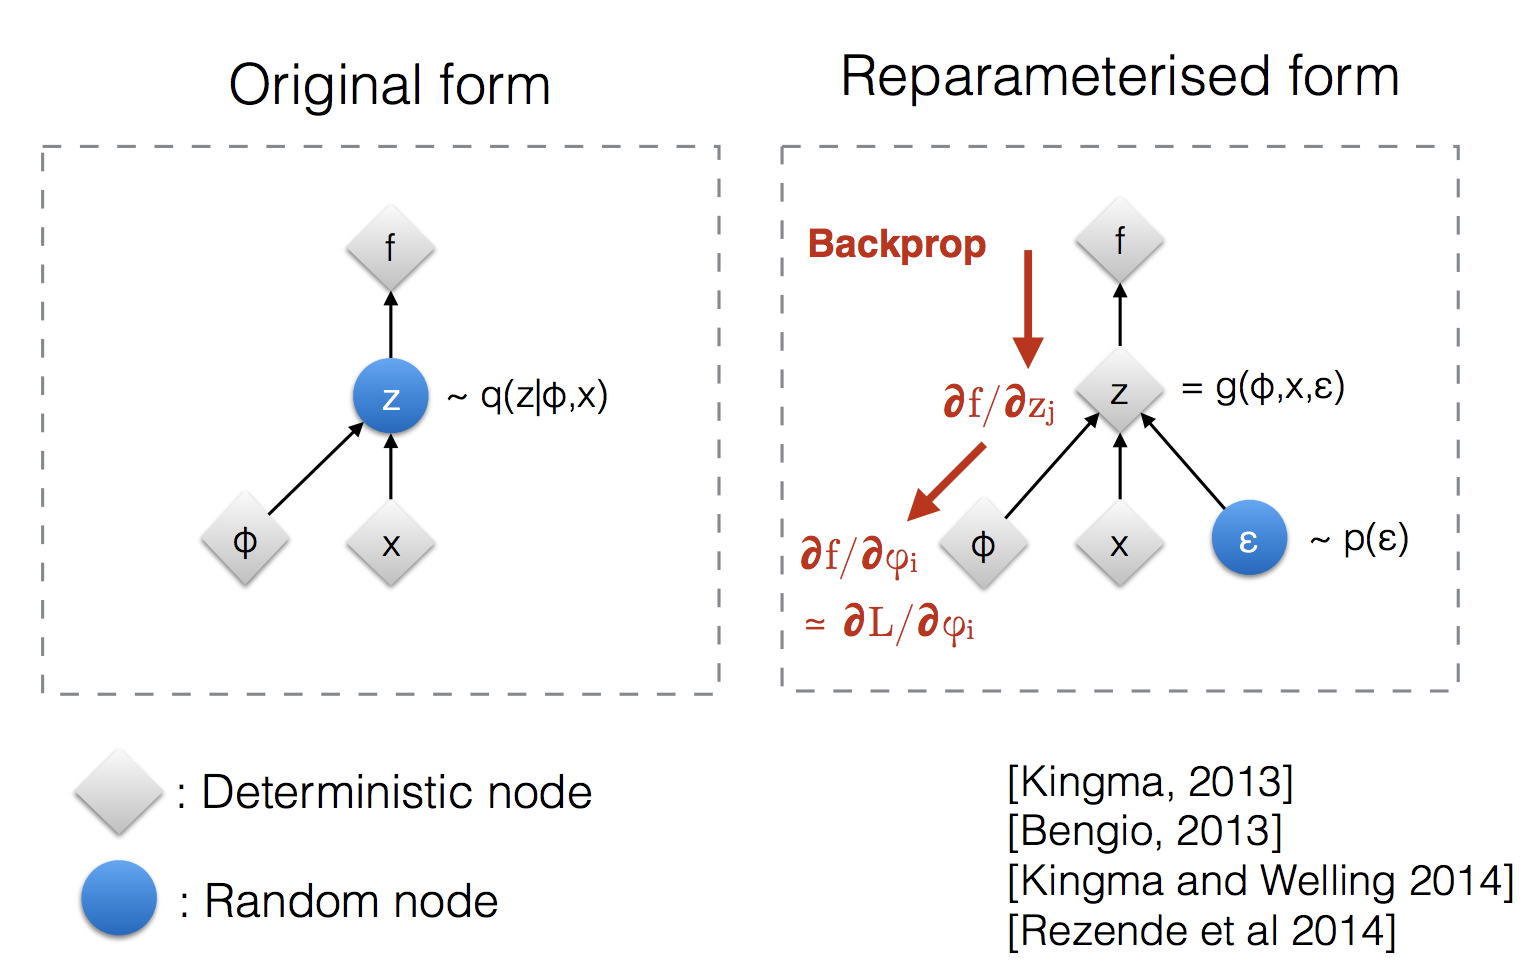

### Лоссы для распределений. ELBO, KL-дивергенция

Это все, конечно хорошо, но пока нам никто не гарантирует, что кластеры будут лежать **близко** и **непрерывно друг к другу**.

Давайте придумаем такой дополнительный Loss, чтобы объекты лежали близко друг к другу.

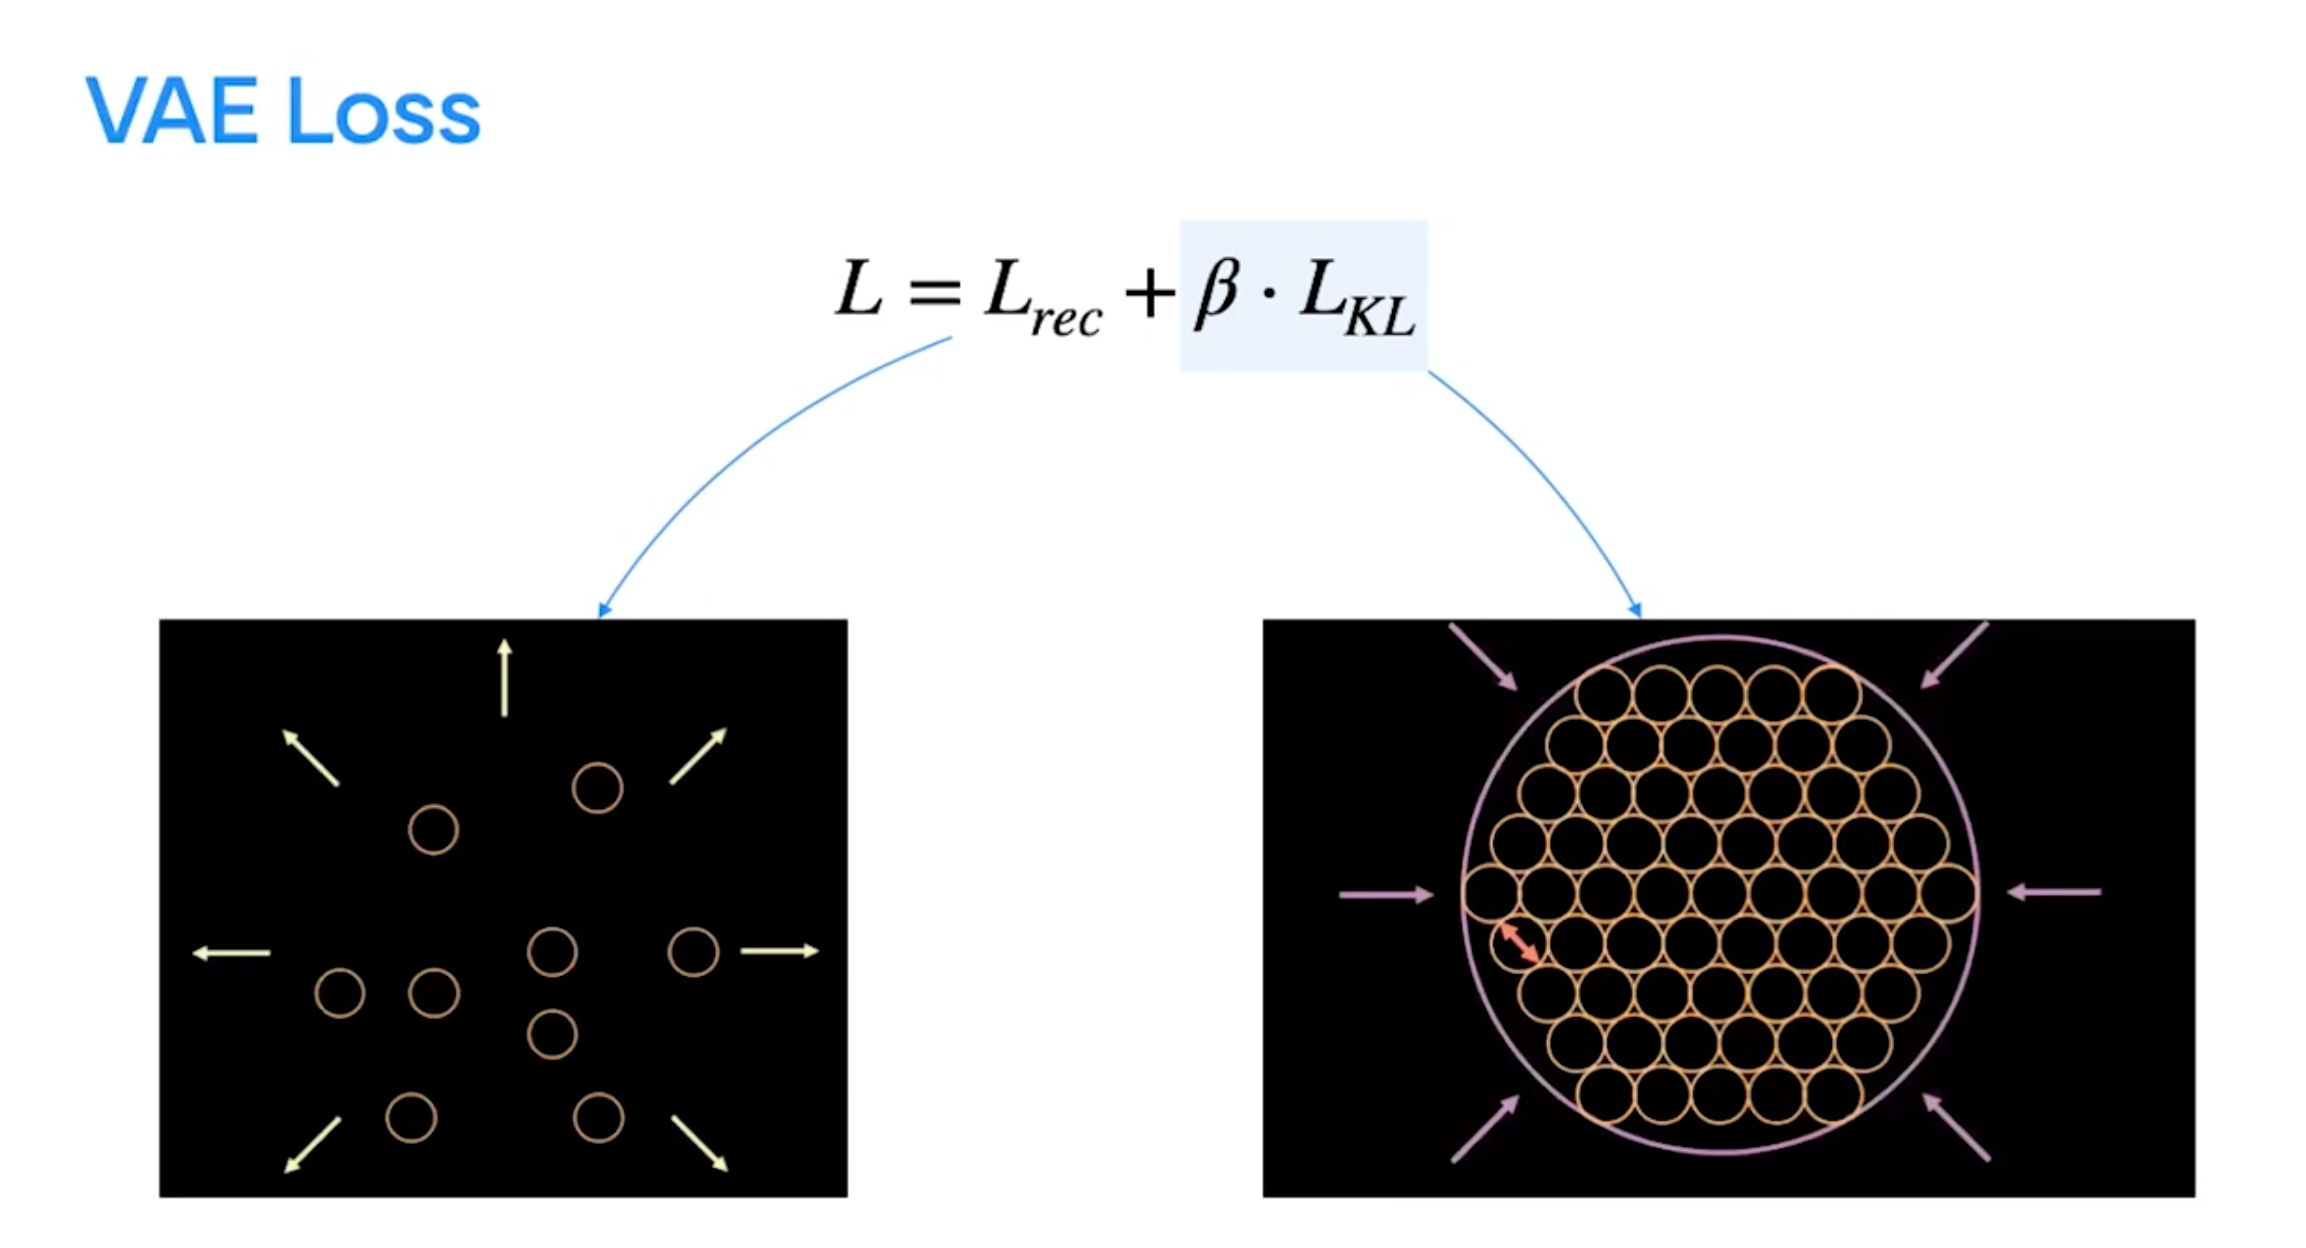

**Идея** - сделаем регуляризацию, которая будет **стремить** каждое наше распределение к $\mathcal{N}(0,1)$

Как бы нам посчитать уровень различий между двумя распределениями?

### KL-дивергенция - подобие энтропии между 2-мя распределениями

$$KL (p||q) = \int_{x \in \mathcal{X}} p(x) \log \left(\frac{q(x)}{p(x)}\right)dx = \mathbb{E}_{x \sim p} \log \left(\frac{q(x)}{p(x)}\right)$$

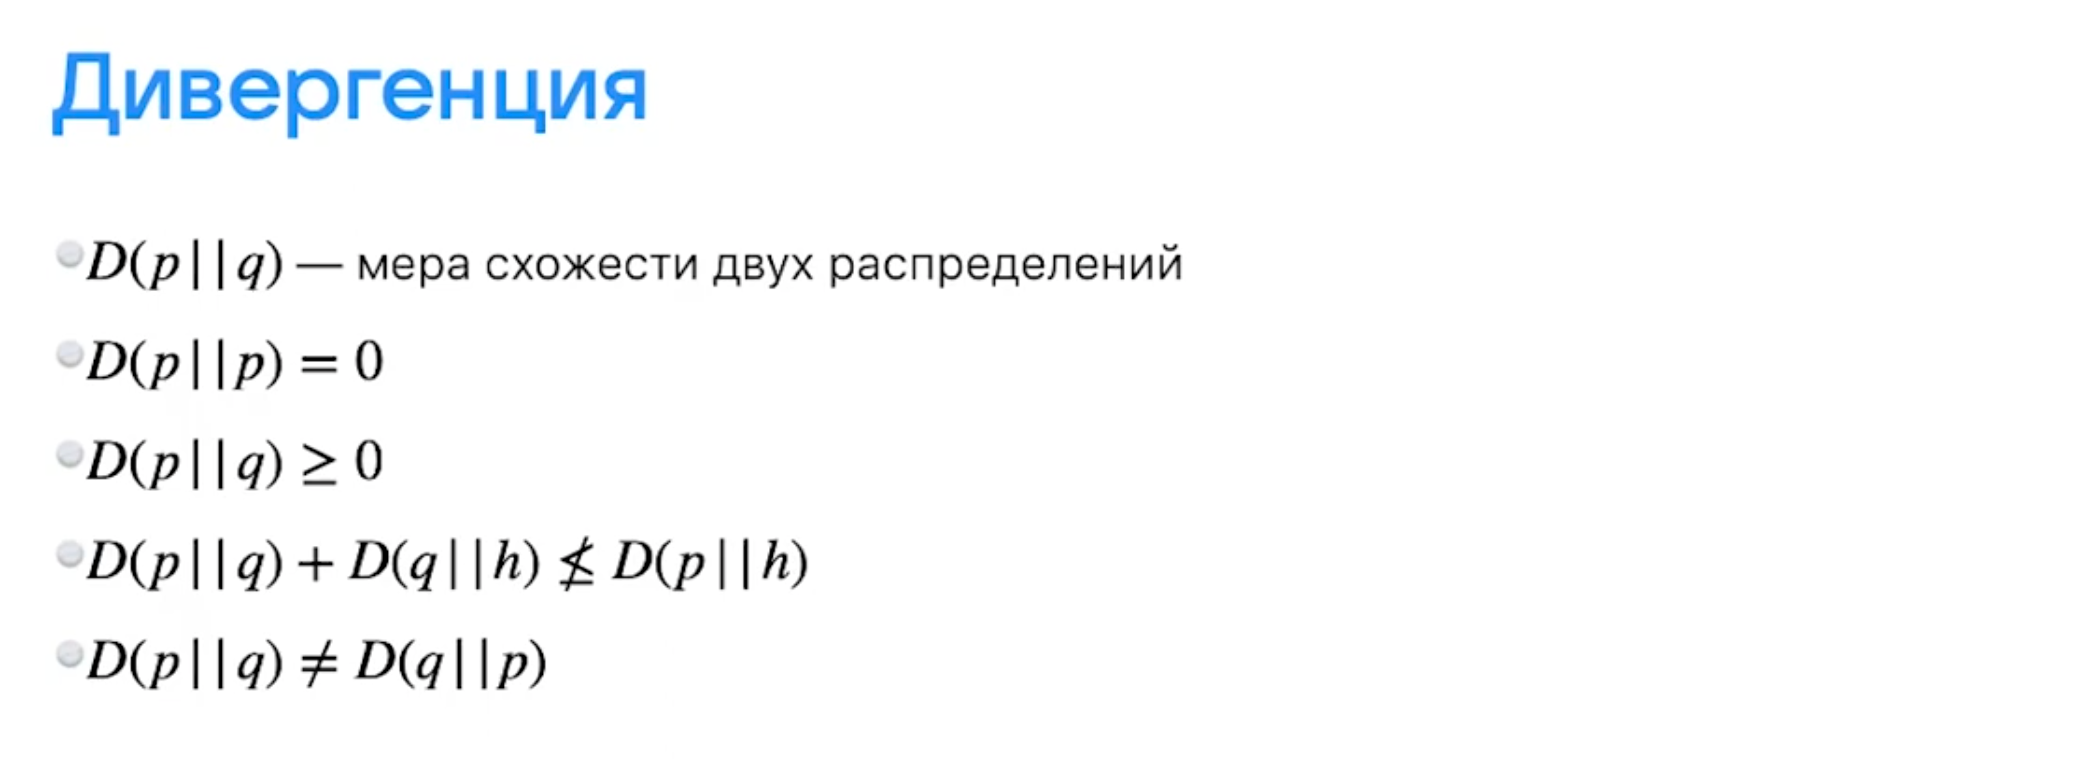

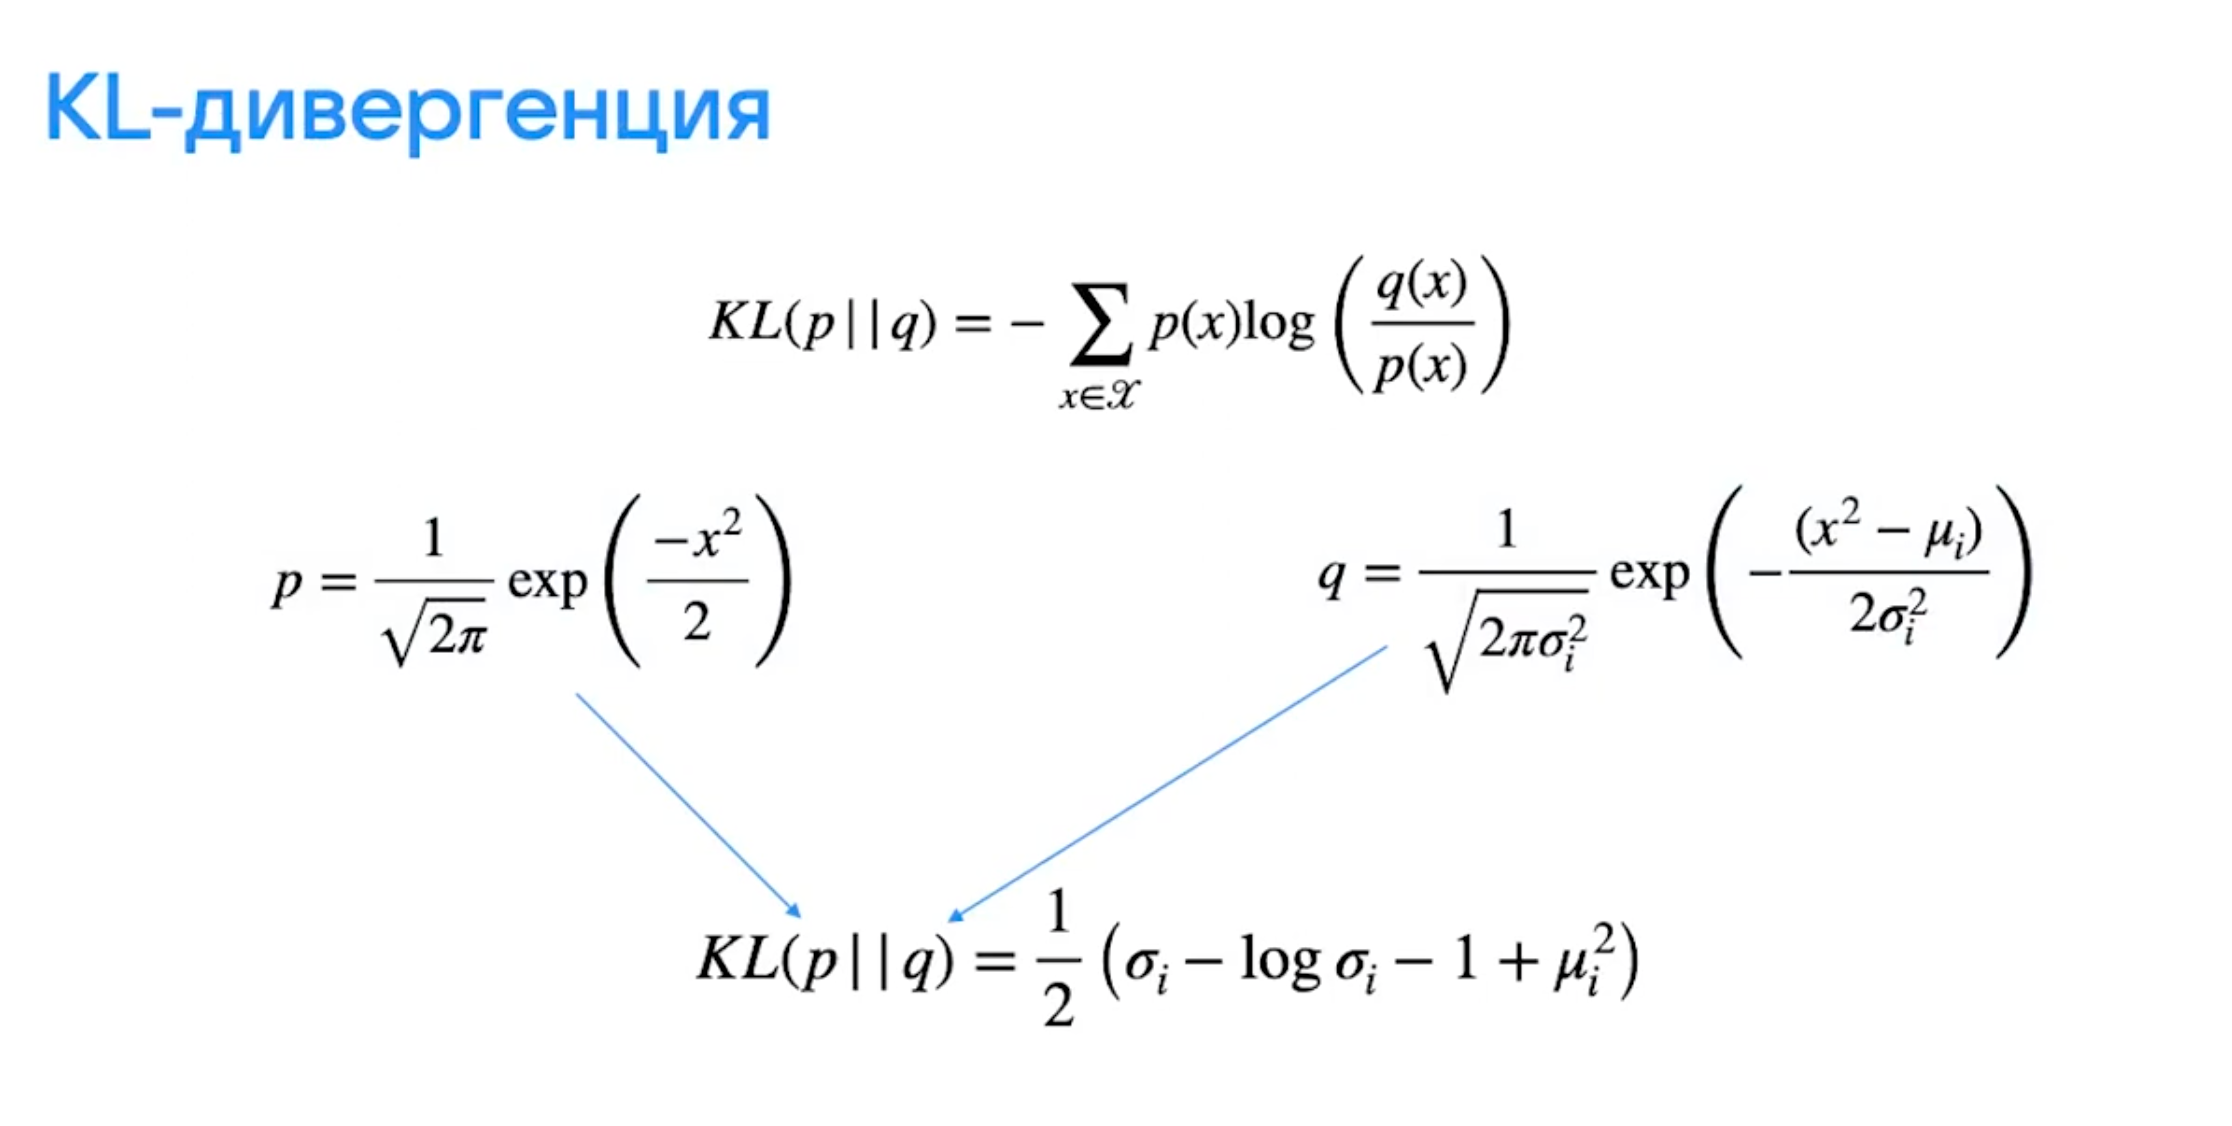

Итого для нашей модели мы возьмем дополнительный лосс 

$$L_{KL} = \frac{1}{2}(\sigma_i - \log\sigma_i - 1 + \mu_i^2)$$

## Какой результат мы от всего этого получим?

### Непрерывное латентное пространство объектов

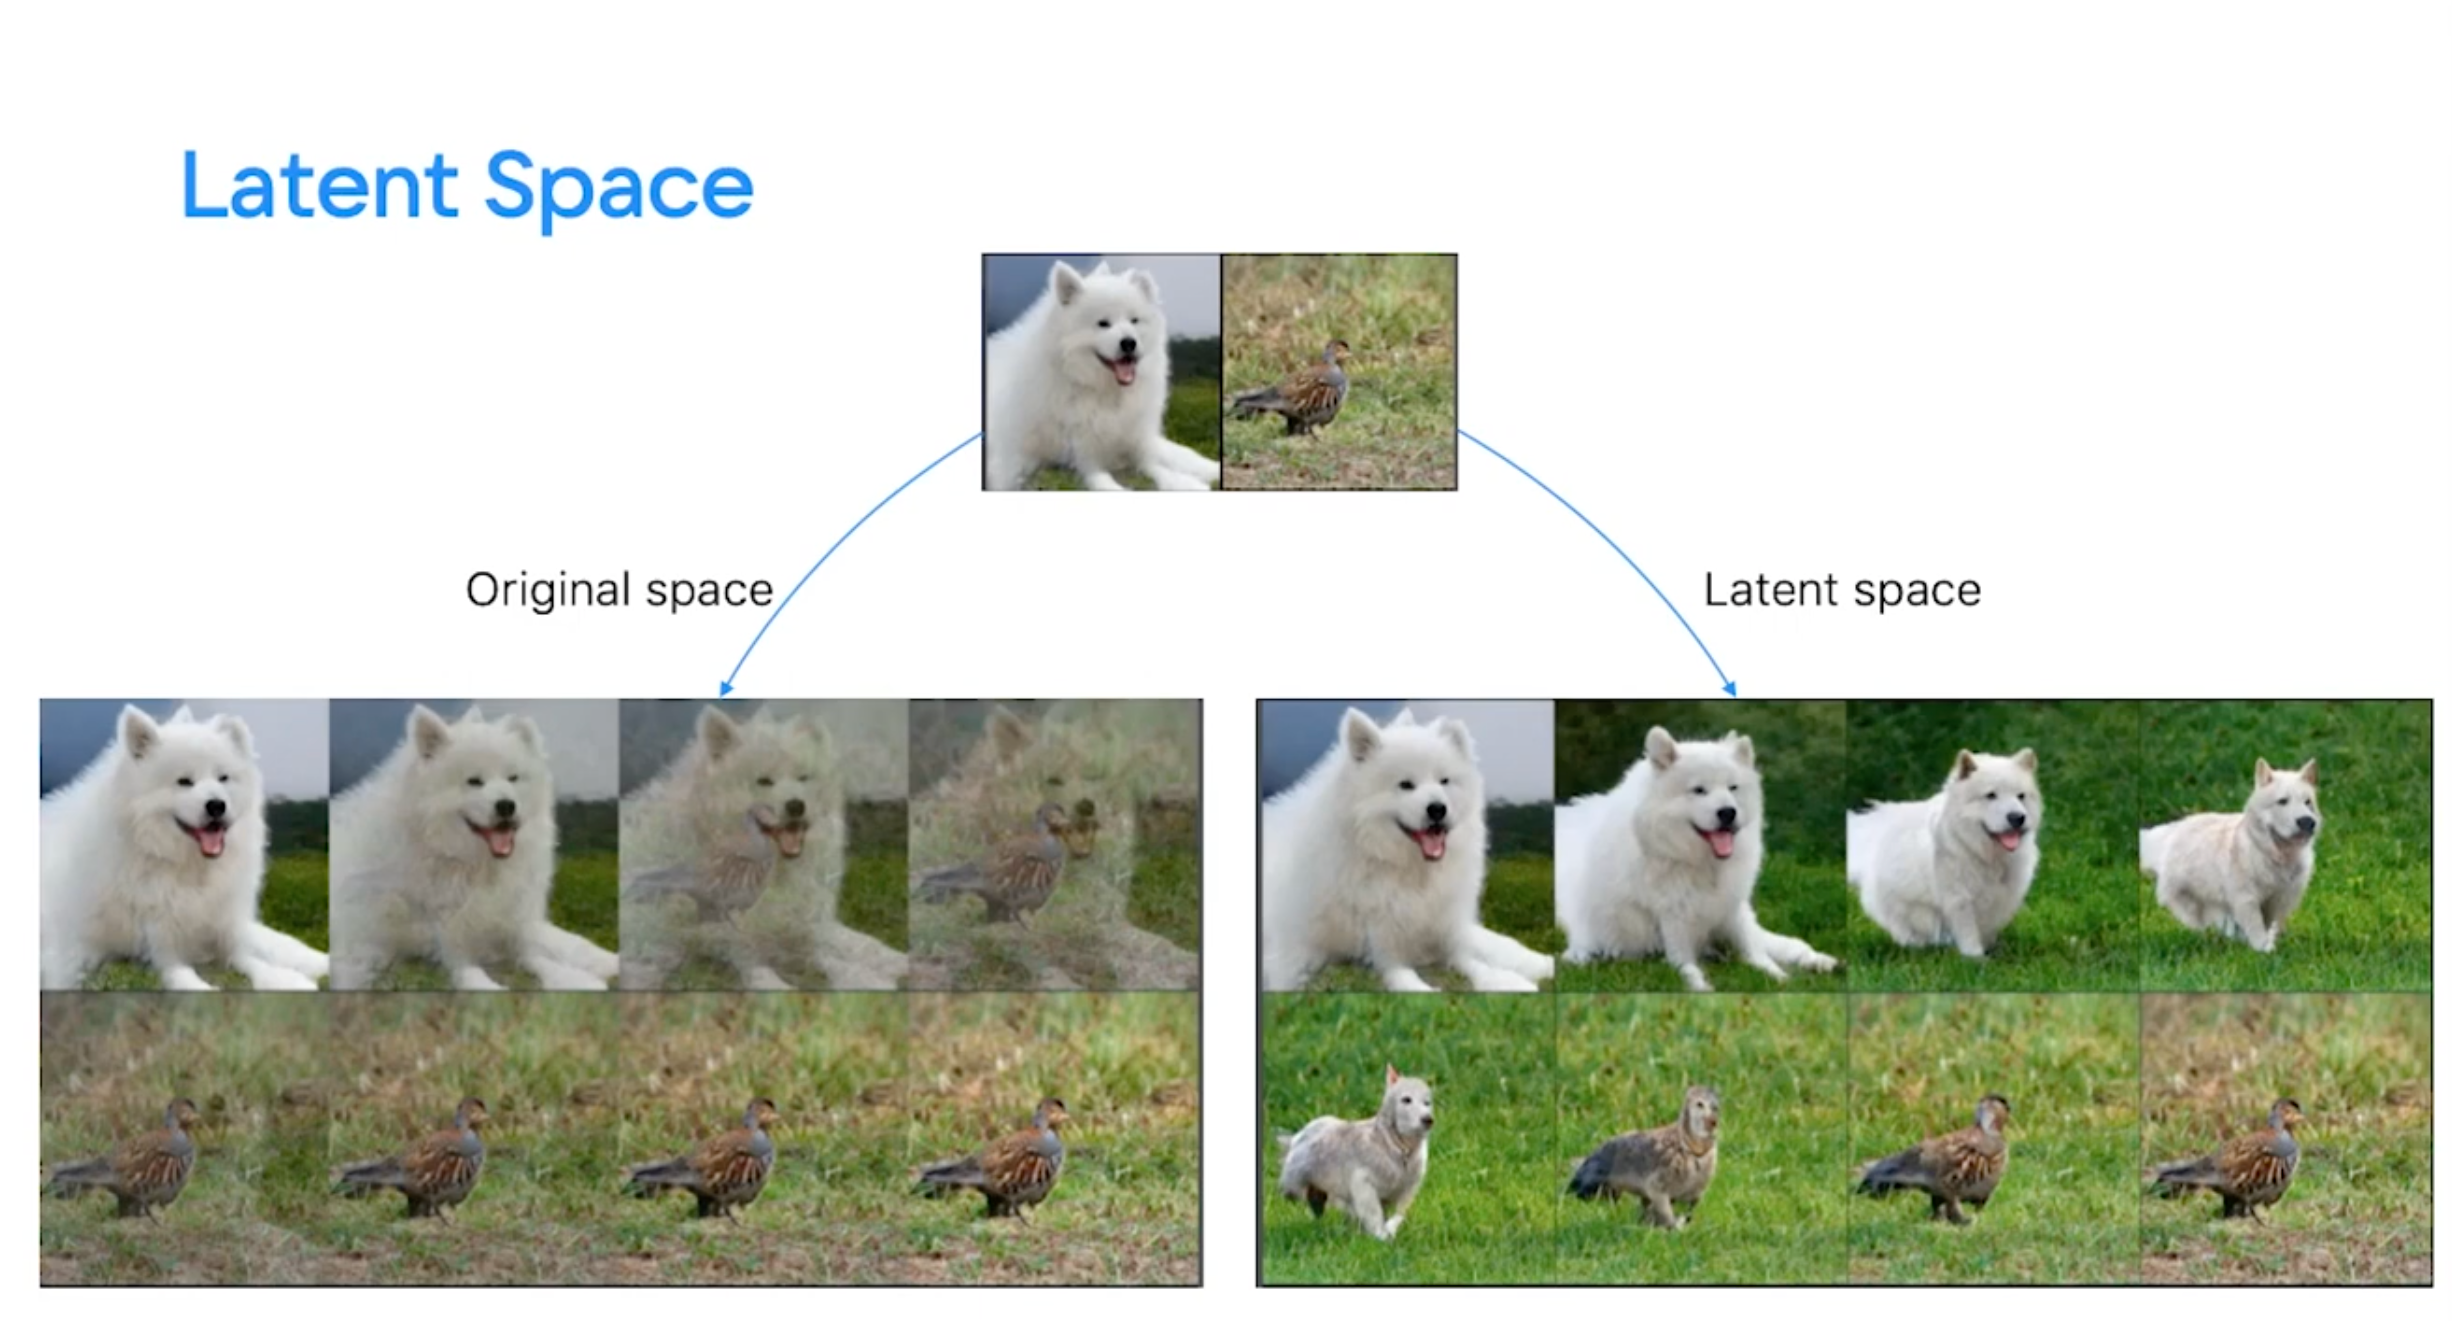

### Эмбеддинги объектов изображений

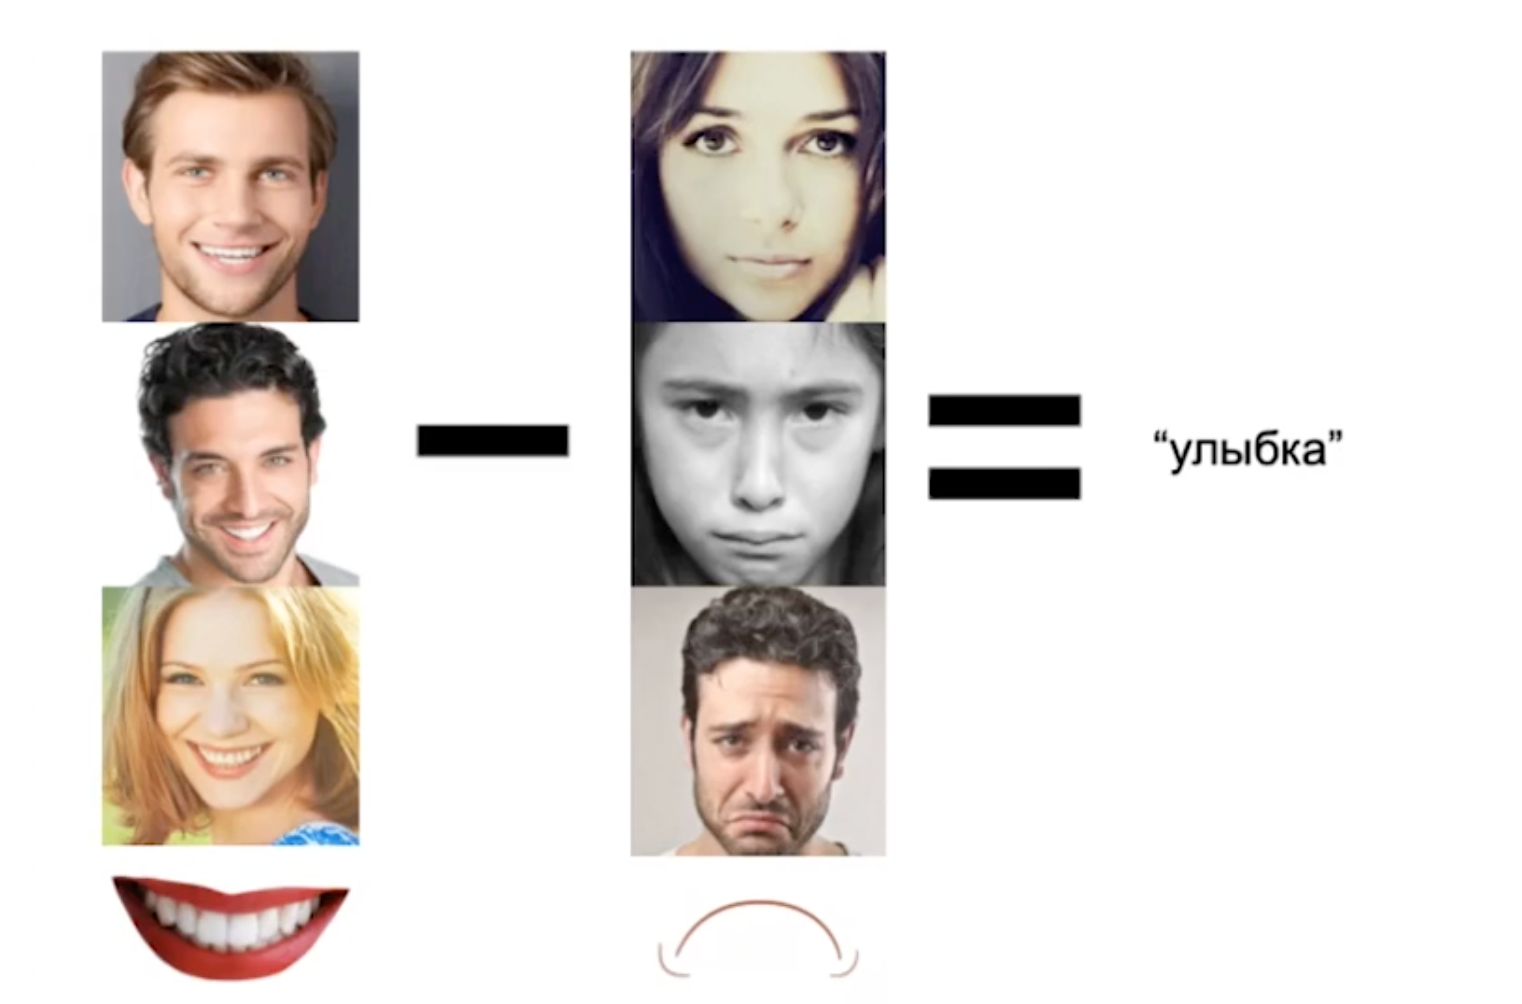

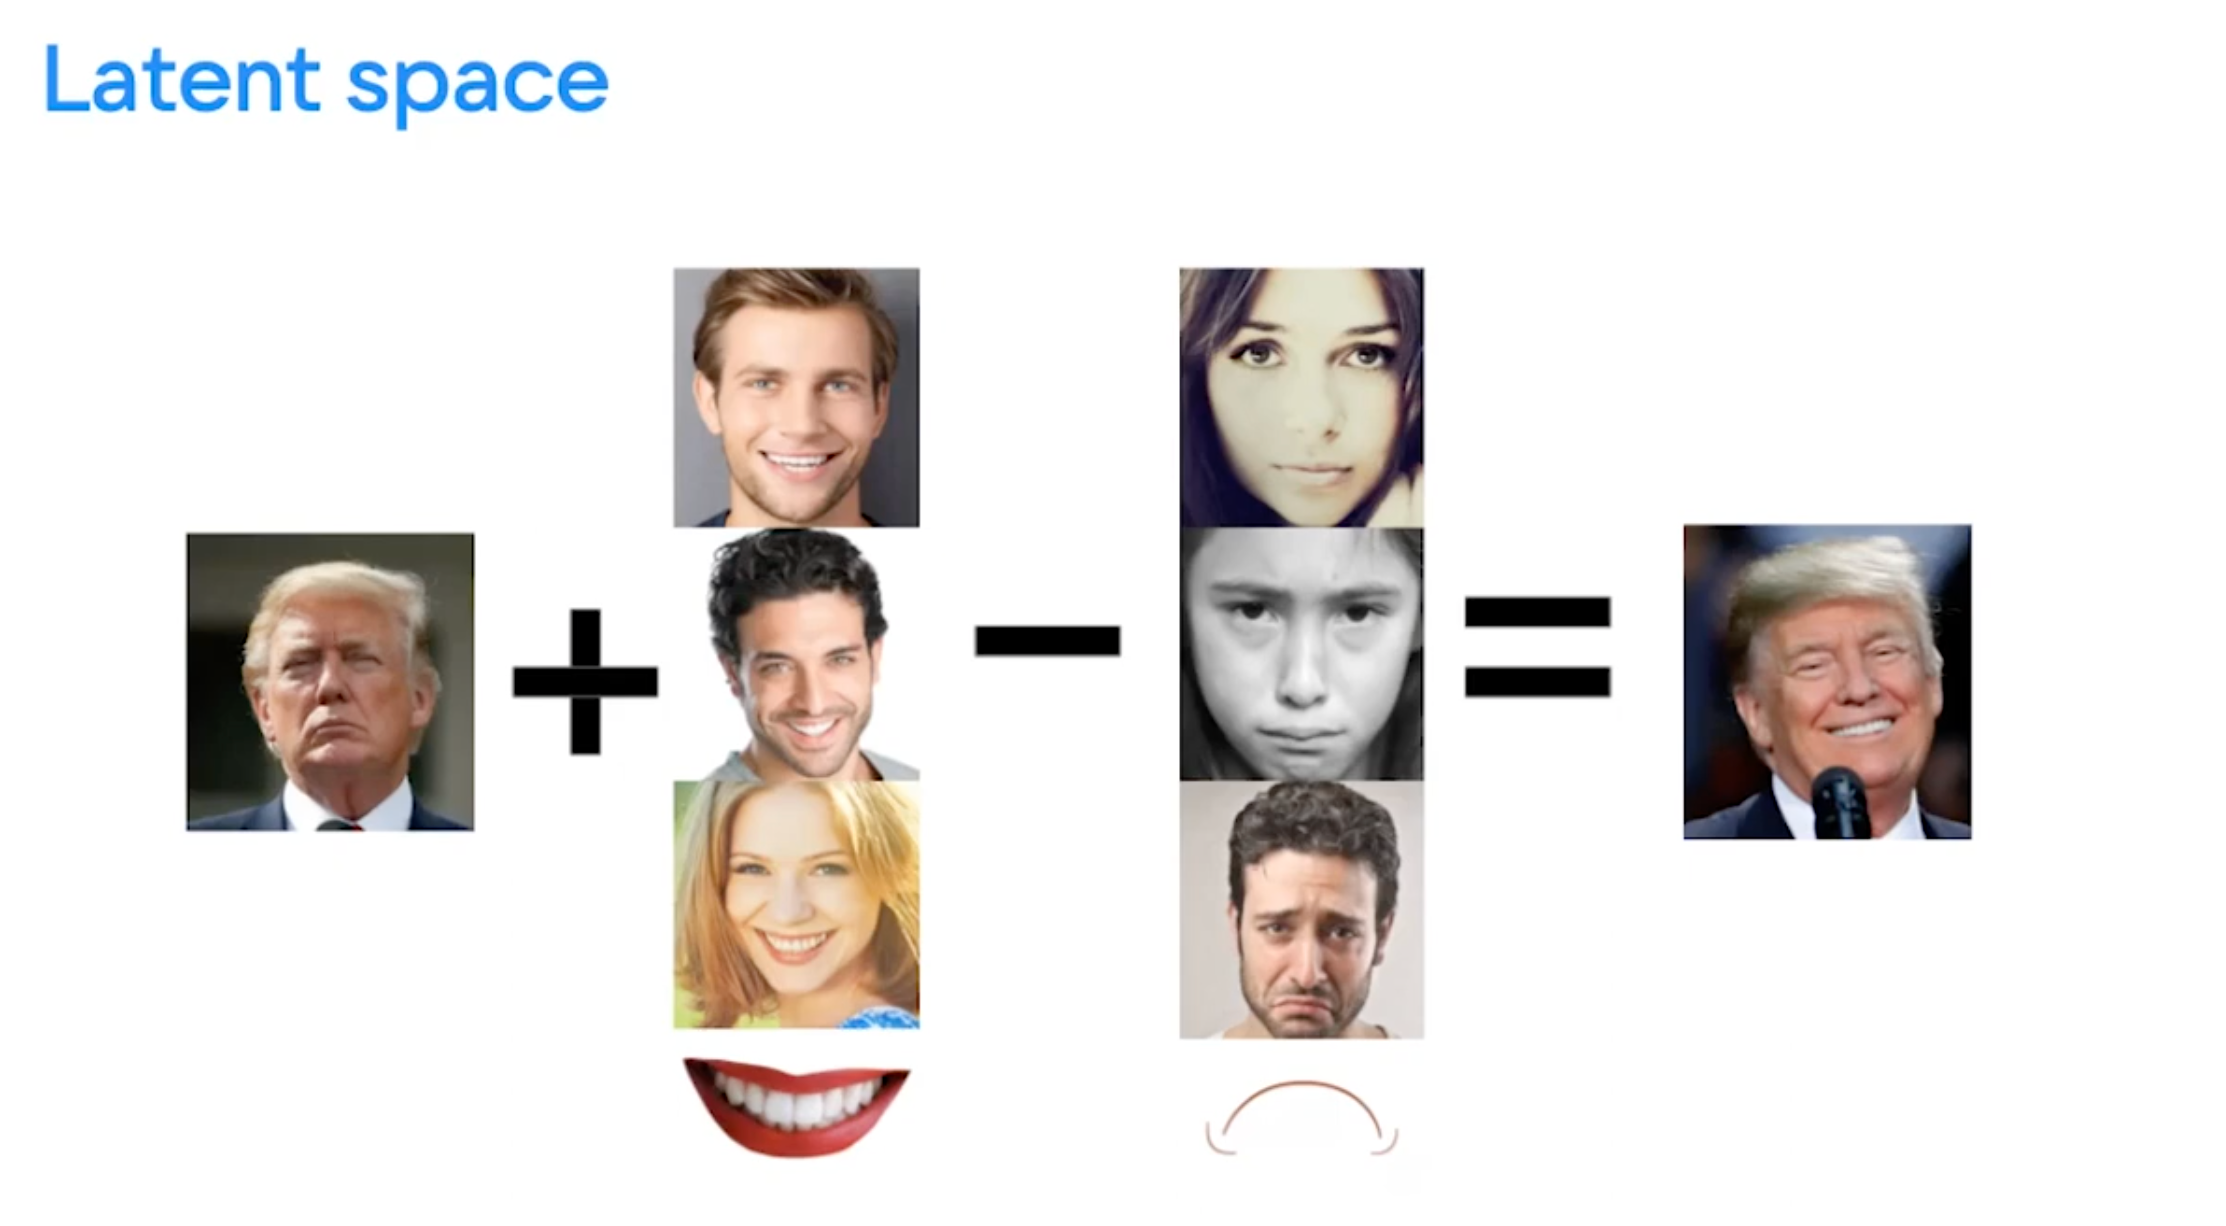

## Переделаем наш пример с одеждой

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import time
import torchvision
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ExponentialLR
from IPython.display import clear_output
import tqdm

%matplotlib inline

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [2]:
# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transforms.ToTensor())

# Download and load the test data
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transforms.ToTensor())

x_train = torch.Tensor([x.numpy() for x, y in trainset][:20000])
x_test  = torch.Tensor([x.numpy() for x, y in testset ][:200])
y_test = testset.targets[:200]

/tmp/ipykernel_22947/788564944.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  x_train = torch.Tensor([x.numpy() for x, y in trainset][:20000])


In [3]:
train_set = torch.utils.data.TensorDataset(x_train, x_train)
train_set, val_set = torch.utils.data.random_split(train_set, [round(len(train_set) * 0.8), round(len(train_set) * 0.2)])
test_set = torch.utils.data.TensorDataset(x_test, x_test)

dataloaders = {
  'train': torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True),
  'val'  : torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False),
  'test' : torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)
}

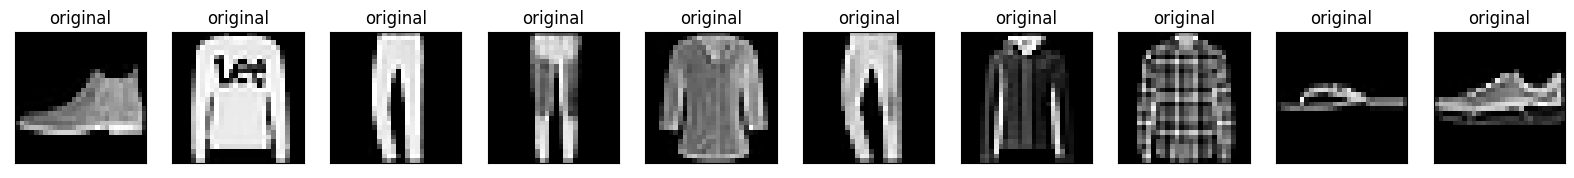

In [4]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i][0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Model


In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=32):
        return input.view(input.size(0), size, 1, 1)

In [6]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=32, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential( #1x28x28
            nn.Conv2d(image_channels, 32, kernel_size=(2,2), stride=2), #32x14x14
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3,3), stride=2), #32x6x6
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(2,2), stride=2), #32x3x3
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3,3)), #32x1x1
            nn.ReLU(),
            Flatten()
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 32, kernel_size=(3,3)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=(3,3), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=(4,4), stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        # получаем вектор из кружочка
        # logvar 
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps #sampling
        return z
    
    def bottleneck(self, h):
        # 
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [7]:
def vae_loss(recon_x, x, mu, logvar, beta=10) -> float:
    BCE = F.binary_cross_entropy(recon_x.view(-1, 128 * 28 * 28), x.view(-1, 128 * 28*28), reduction='sum')
    KLD = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Training

In [14]:
model = VAE(z_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler=ExponentialLR(optimizer, gamma=0.999)

In [15]:
num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0
    for image, _ in tqdm.tqdm(dataloaders['train']):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(image)
        loss = vae_loss(recon_batch, image, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    scheduler.step()
        
    print('epoch %d, loss %.4f' % (epoch, train_loss))

model.eval()

100%|██████████| 125/125 [00:00<00:00, 133.98it/s]


epoch 0, loss 6703828.0234


100%|██████████| 125/125 [00:00<00:00, 139.05it/s]


epoch 1, loss 5229250.3320


100%|██████████| 125/125 [00:00<00:00, 142.83it/s]


epoch 2, loss 5111327.8438


100%|██████████| 125/125 [00:00<00:00, 138.99it/s]


epoch 3, loss 5043563.0117


100%|██████████| 125/125 [00:00<00:00, 147.21it/s]


epoch 4, loss 5010446.6953


100%|██████████| 125/125 [00:00<00:00, 147.12it/s]


epoch 5, loss 4990162.3008


100%|██████████| 125/125 [00:00<00:00, 137.54it/s]


epoch 6, loss 4963920.0312


100%|██████████| 125/125 [00:00<00:00, 143.54it/s]


epoch 7, loss 4951549.5703


100%|██████████| 125/125 [00:00<00:00, 145.90it/s]


epoch 8, loss 4942974.7383


100%|██████████| 125/125 [00:00<00:00, 145.63it/s]


epoch 9, loss 4935923.4336


100%|██████████| 125/125 [00:00<00:00, 144.96it/s]


epoch 10, loss 4925005.3711


100%|██████████| 125/125 [00:00<00:00, 143.51it/s]


epoch 11, loss 4918131.3008


100%|██████████| 125/125 [00:00<00:00, 143.27it/s]


epoch 12, loss 4915341.1289


100%|██████████| 125/125 [00:00<00:00, 144.04it/s]


epoch 13, loss 4908188.7422


100%|██████████| 125/125 [00:00<00:00, 146.40it/s]


epoch 14, loss 4908399.0586


100%|██████████| 125/125 [00:00<00:00, 143.49it/s]


epoch 15, loss 4899049.3125


100%|██████████| 125/125 [00:00<00:00, 137.13it/s]


epoch 16, loss 4895885.6875


100%|██████████| 125/125 [00:00<00:00, 135.90it/s]


epoch 17, loss 4894168.0859


100%|██████████| 125/125 [00:00<00:00, 143.81it/s]


epoch 18, loss 4891504.7734


100%|██████████| 125/125 [00:00<00:00, 137.76it/s]


epoch 19, loss 4885928.5234


100%|██████████| 125/125 [00:00<00:00, 144.89it/s]


epoch 20, loss 4883727.1289


100%|██████████| 125/125 [00:00<00:00, 141.07it/s]


epoch 21, loss 4887395.2617


100%|██████████| 125/125 [00:00<00:00, 139.88it/s]


epoch 22, loss 4881505.1328


100%|██████████| 125/125 [00:00<00:00, 145.84it/s]


epoch 23, loss 4878994.4062


100%|██████████| 125/125 [00:00<00:00, 144.76it/s]


epoch 24, loss 4871918.8164


100%|██████████| 125/125 [00:00<00:00, 146.01it/s]


epoch 25, loss 4872426.2422


100%|██████████| 125/125 [00:00<00:00, 143.18it/s]


epoch 26, loss 4873471.9961


100%|██████████| 125/125 [00:00<00:00, 146.13it/s]


epoch 27, loss 4868265.5781


100%|██████████| 125/125 [00:00<00:00, 145.81it/s]


epoch 28, loss 4861729.4922


100%|██████████| 125/125 [00:00<00:00, 145.04it/s]


epoch 29, loss 4867551.7969


100%|██████████| 125/125 [00:00<00:00, 143.20it/s]


epoch 30, loss 4862064.3828


100%|██████████| 125/125 [00:00<00:00, 139.15it/s]


epoch 31, loss 4865947.0781


100%|██████████| 125/125 [00:00<00:00, 142.96it/s]


epoch 32, loss 4858622.7852


100%|██████████| 125/125 [00:00<00:00, 141.19it/s]


epoch 33, loss 4853750.7188


100%|██████████| 125/125 [00:00<00:00, 141.54it/s]


epoch 34, loss 4853174.2344


100%|██████████| 125/125 [00:00<00:00, 142.45it/s]


epoch 35, loss 4856293.1094


100%|██████████| 125/125 [00:00<00:00, 139.40it/s]


epoch 36, loss 4854102.1797


100%|██████████| 125/125 [00:00<00:00, 142.33it/s]


epoch 37, loss 4848714.9766


100%|██████████| 125/125 [00:00<00:00, 137.51it/s]


epoch 38, loss 4849959.4727


100%|██████████| 125/125 [00:00<00:00, 144.71it/s]


epoch 39, loss 4855977.4531


100%|██████████| 125/125 [00:00<00:00, 144.03it/s]


epoch 40, loss 4847724.4883


100%|██████████| 125/125 [00:00<00:00, 141.32it/s]


epoch 41, loss 4843432.3398


100%|██████████| 125/125 [00:00<00:00, 143.29it/s]


epoch 42, loss 4842814.3398


100%|██████████| 125/125 [00:00<00:00, 143.56it/s]


epoch 43, loss 4841728.2188


100%|██████████| 125/125 [00:00<00:00, 140.59it/s]


epoch 44, loss 4840706.6680


100%|██████████| 125/125 [00:00<00:00, 144.28it/s]


epoch 45, loss 4839773.9141


100%|██████████| 125/125 [00:00<00:00, 147.70it/s]


epoch 46, loss 4839001.7812


100%|██████████| 125/125 [00:00<00:00, 147.84it/s]


epoch 47, loss 4836564.7891


100%|██████████| 125/125 [00:00<00:00, 145.49it/s]


epoch 48, loss 4839110.2188


100%|██████████| 125/125 [00:00<00:00, 148.19it/s]


epoch 49, loss 4837846.2773


100%|██████████| 125/125 [00:00<00:00, 147.69it/s]


epoch 50, loss 4831717.0898


100%|██████████| 125/125 [00:00<00:00, 146.32it/s]


epoch 51, loss 4833713.4648


100%|██████████| 125/125 [00:00<00:00, 147.78it/s]


epoch 52, loss 4832394.6719


100%|██████████| 125/125 [00:00<00:00, 146.74it/s]


epoch 53, loss 4829647.7227


100%|██████████| 125/125 [00:00<00:00, 141.41it/s]


epoch 54, loss 4830637.9844


100%|██████████| 125/125 [00:00<00:00, 147.42it/s]


epoch 55, loss 4826587.4023


100%|██████████| 125/125 [00:00<00:00, 149.21it/s]


epoch 56, loss 4828056.5312


100%|██████████| 125/125 [00:00<00:00, 149.56it/s]


epoch 57, loss 4827596.6016


100%|██████████| 125/125 [00:00<00:00, 148.44it/s]


epoch 58, loss 4825103.0039


100%|██████████| 125/125 [00:00<00:00, 147.30it/s]


epoch 59, loss 4826697.9531


100%|██████████| 125/125 [00:00<00:00, 147.18it/s]


epoch 60, loss 4823341.8281


100%|██████████| 125/125 [00:00<00:00, 145.32it/s]


epoch 61, loss 4824577.8086


100%|██████████| 125/125 [00:00<00:00, 144.58it/s]


epoch 62, loss 4824472.3867


100%|██████████| 125/125 [00:00<00:00, 144.43it/s]


epoch 63, loss 4827364.1133


100%|██████████| 125/125 [00:00<00:00, 134.17it/s]


epoch 64, loss 4821068.9141


100%|██████████| 125/125 [00:00<00:00, 144.36it/s]


epoch 65, loss 4822057.9141


100%|██████████| 125/125 [00:00<00:00, 141.93it/s]


epoch 66, loss 4825296.4648


100%|██████████| 125/125 [00:00<00:00, 141.05it/s]


epoch 67, loss 4819530.1719


100%|██████████| 125/125 [00:00<00:00, 143.75it/s]


epoch 68, loss 4820094.9727


100%|██████████| 125/125 [00:00<00:00, 144.93it/s]


epoch 69, loss 4817768.3711


100%|██████████| 125/125 [00:00<00:00, 145.03it/s]


epoch 70, loss 4819398.0469


100%|██████████| 125/125 [00:00<00:00, 145.47it/s]


epoch 71, loss 4817140.3555


100%|██████████| 125/125 [00:00<00:00, 146.77it/s]


epoch 72, loss 4814232.3633


100%|██████████| 125/125 [00:00<00:00, 146.92it/s]


epoch 73, loss 4816862.6602


100%|██████████| 125/125 [00:00<00:00, 146.32it/s]


epoch 74, loss 4815430.7891


100%|██████████| 125/125 [00:00<00:00, 144.17it/s]


epoch 75, loss 4817557.5742


100%|██████████| 125/125 [00:00<00:00, 145.25it/s]


epoch 76, loss 4813584.7383


100%|██████████| 125/125 [00:00<00:00, 147.12it/s]


epoch 77, loss 4811581.7305


100%|██████████| 125/125 [00:00<00:00, 142.99it/s]


epoch 78, loss 4813087.3828


100%|██████████| 125/125 [00:00<00:00, 141.57it/s]


epoch 79, loss 4814681.1484


100%|██████████| 125/125 [00:00<00:00, 146.17it/s]


epoch 80, loss 4814379.0078


100%|██████████| 125/125 [00:00<00:00, 142.75it/s]


epoch 81, loss 4812330.5938


100%|██████████| 125/125 [00:00<00:00, 147.67it/s]


epoch 82, loss 4815058.1055


100%|██████████| 125/125 [00:00<00:00, 147.43it/s]


epoch 83, loss 4809302.5234


100%|██████████| 125/125 [00:00<00:00, 146.25it/s]


epoch 84, loss 4812114.4922


100%|██████████| 125/125 [00:00<00:00, 143.57it/s]


epoch 85, loss 4809317.5820


100%|██████████| 125/125 [00:00<00:00, 146.97it/s]


epoch 86, loss 4809348.4375


100%|██████████| 125/125 [00:00<00:00, 147.45it/s]


epoch 87, loss 4809898.4844


100%|██████████| 125/125 [00:00<00:00, 145.20it/s]


epoch 88, loss 4806339.8320


100%|██████████| 125/125 [00:00<00:00, 142.72it/s]


epoch 89, loss 4808120.4180


100%|██████████| 125/125 [00:00<00:00, 144.87it/s]


epoch 90, loss 4815161.0742


100%|██████████| 125/125 [00:00<00:00, 146.09it/s]


epoch 91, loss 4807119.5156


100%|██████████| 125/125 [00:00<00:00, 145.50it/s]


epoch 92, loss 4809257.7500


100%|██████████| 125/125 [00:00<00:00, 145.70it/s]


epoch 93, loss 4804959.4219


100%|██████████| 125/125 [00:00<00:00, 143.34it/s]


epoch 94, loss 4806821.8516


100%|██████████| 125/125 [00:00<00:00, 144.64it/s]


epoch 95, loss 4805565.7422


100%|██████████| 125/125 [00:00<00:00, 144.11it/s]


epoch 96, loss 4805600.1680


100%|██████████| 125/125 [00:00<00:00, 143.89it/s]


epoch 97, loss 4804983.3945


100%|██████████| 125/125 [00:00<00:00, 142.85it/s]


epoch 98, loss 4803701.6758


100%|██████████| 125/125 [00:00<00:00, 147.93it/s]

epoch 99, loss 4801576.5508


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Flatten()
  )
  (h2mu): Linear(in_features=32, out_features=2, bias=True)
  (h2sigma): Linear(in_features=32, out_features=2, bias=True)
  (z2h): Linear(in_features=2, out_features=32, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
    (8): Sigmoid()
  )
)

## Реконструкция 

In [16]:
encoded_imgs = model.encode(x_test)
decoded_imgs = model.decode(encoded_imgs)


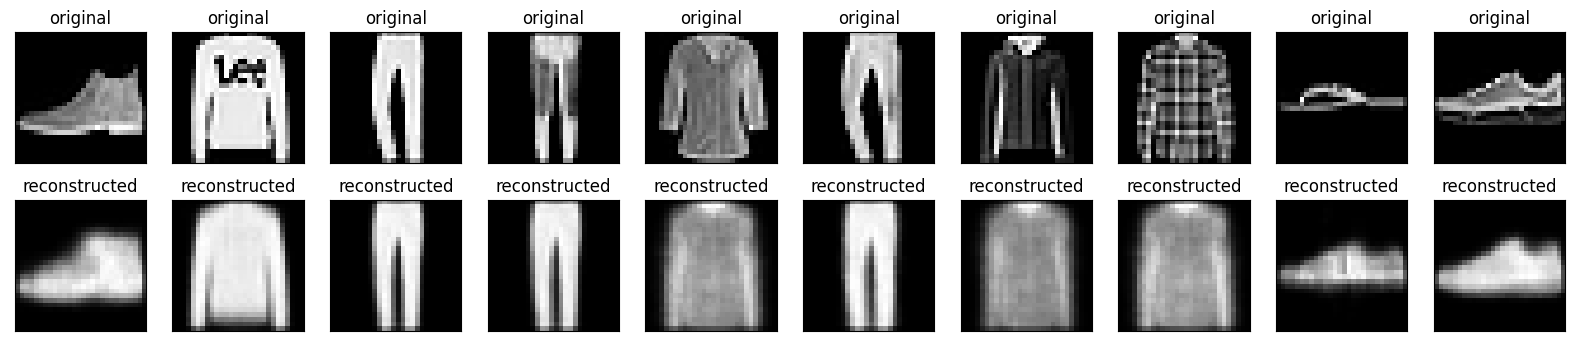

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i][0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i][0].detach().numpy())
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(10, 2)
(10, 2)
(200, 2)
(10, 2)


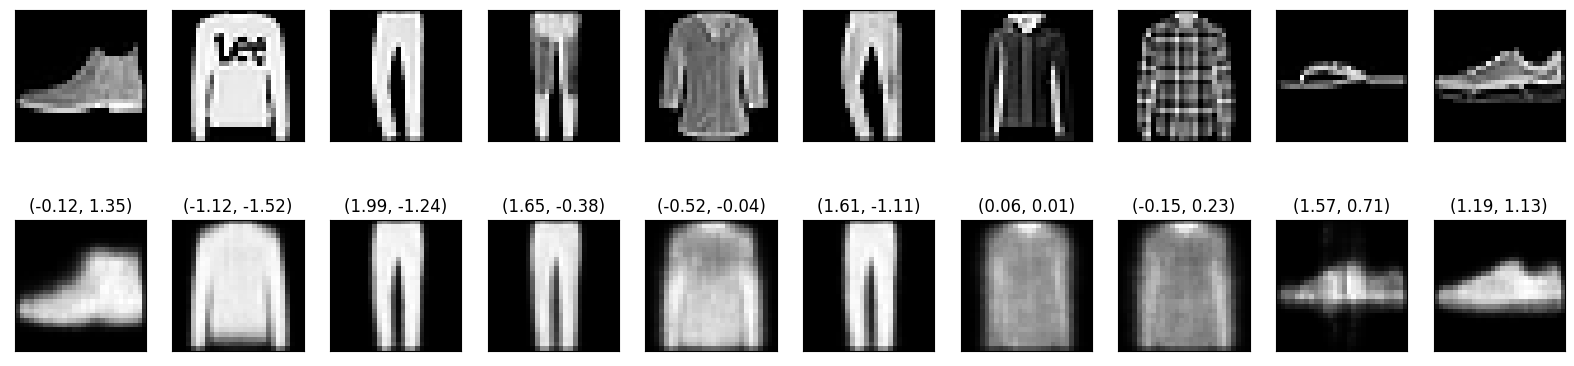

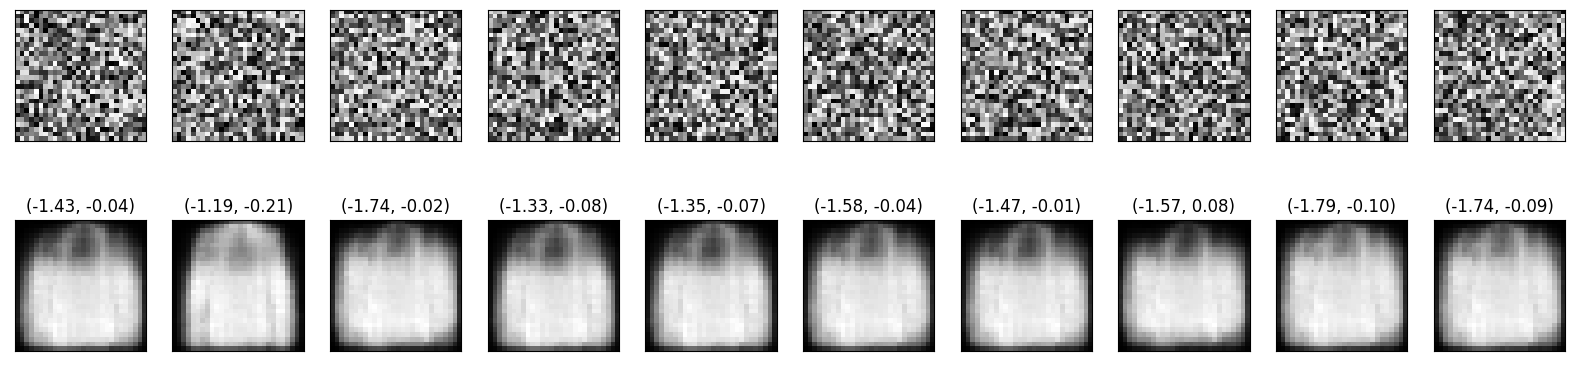

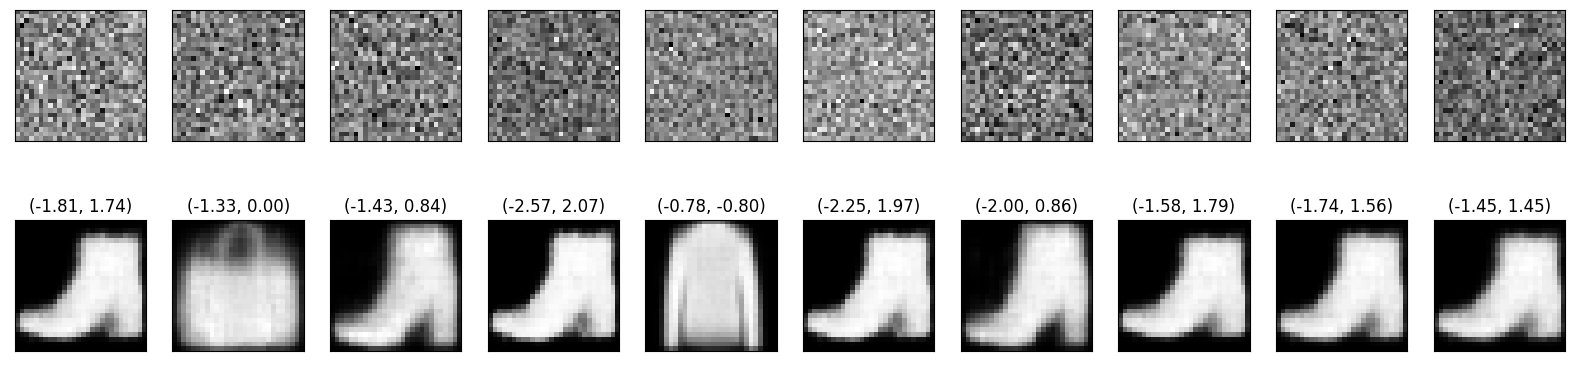

In [26]:
import scipy

def get_triple(inputs, model):
    latent_repr = model.encode(inputs)
    outputs = model.decode(latent_repr).detach().numpy()
    latent_repr = latent_repr.detach().numpy()
    print(latent_repr.shape)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs

def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2*n, 5))
    for i in range(n):
        axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
show_encodings(*get_triple(x_test[:10], model))

inputs = np.random.random(size=(10, 1, 28, 28))
inputs = torch.Tensor(inputs)
show_encodings(*get_triple(inputs, model))

_, latents, _ = get_triple(x_test, model)
latents = latents.ravel()

inputs = np.random.normal(loc=np.mean(latents), scale=2.72, size=(10, 1, 28, 28))
inputs = torch.Tensor(inputs)
show_encodings(*get_triple(inputs, model))

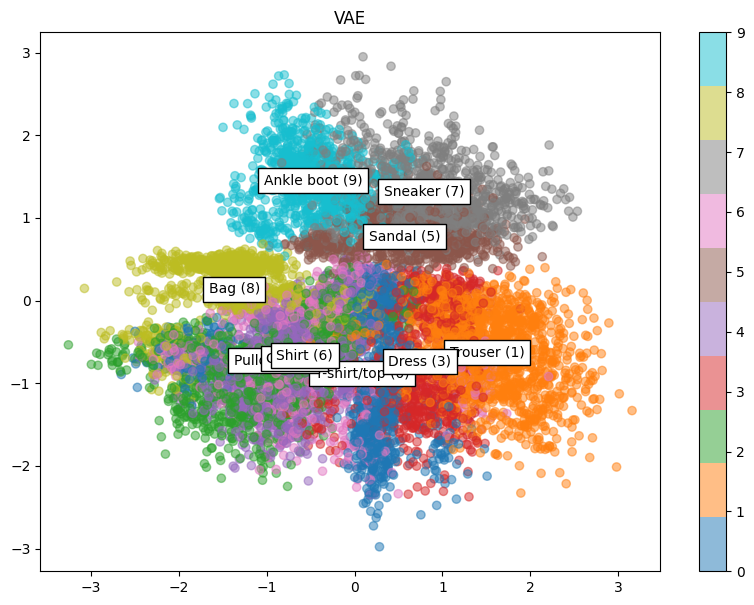

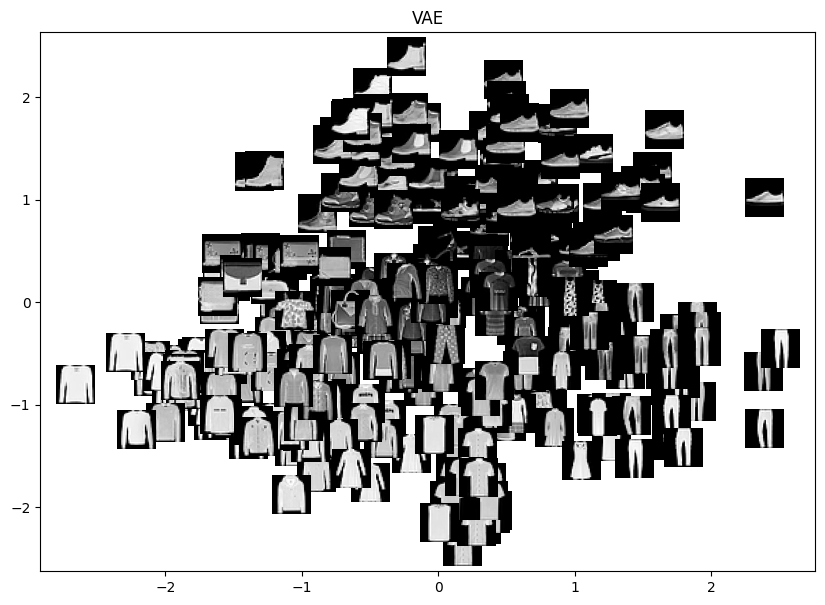

In [28]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea

labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def plot_latent(mode, count, technique):
    idx = np.random.choice(len(x_test), count)
    inputs = x_test[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'VAE':
        coords = model.encode(inputs).detach().numpy()

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = y_test[idx]
        plt.scatter(coords[:, 0], coords[:, 1], c=classes, cmap='tab10', alpha=.5)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{} ({})'.format(labeldict[i], i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

plot_latent('dots', 10000, 'VAE')
plot_latent('imgs', 300, 'VAE')

# Полезные ссылки
* [Генерация музыки с помощью VAE](https://www.kaggle.com/code/basu369victor/generate-music-with-variational-autoencoder)
* [VAE на датасете H&M](https://www.kaggle.com/code/manatoyaguchi/h-m-variational-autoencoder-with-pytorch)
* [нейрохайв](https://neurohive.io/ru/osnovy-data-science/variacionnyj-avtojenkoder-vae/)
* [вики](https://en.wikipedia.org/wiki/Variational_autoencoder)
* [основная статья](https://arxiv.org/pdf/1906.02691.pdf)
* [еще одна хорошая статья](https://waksoft.susu.ru/2021/07/08/generativnaya-i-diskriminaczionnaya-modeli/)
* [прям вообще кайф](https://lilianweng.github.io/posts/2018-08-12-vae/)